[View in Colaboratory](https://colab.research.google.com/github/BUPT/awesome-chatbot/blob/master/code/CAIC_9_demo_of_VAE_Auto_Poem.ipynb)

# CAIC #9 - Example of VAE : Auto-Poem

### Reference:
- https://github.com/bojone/vae
- https://kexue.fm/archives/5253

### Author: [824zzy](https://github.com/824zzy)

## DEMO: Auto-Poem


In [1]:
!apt-get install graphviz
!pip install pydot graphviz easydict

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,154 kB o

In [0]:
#! -*- coding:utf-8 -*-
import re
import codecs
import numpy as np
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras.callbacks import Callback
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### 数据预处理：文本数据使用的是全唐诗
[全唐诗下载地址](https://raw.githubusercontent.com/824zzy/blogResources/master/txtRestources/poems.txt)

In [8]:
!wget https://raw.githubusercontent.com/824zzy/blogResources/master/txtRestources/poems.txt

--2018-10-23 09:33:09--  https://raw.githubusercontent.com/824zzy/blogResources/master/txtRestources/poems.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12639039 (12M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]  12.05M  78.4MB/s    in 0.2s    

2018-10-23 09:33:09 (78.4 MB/s) - ‘poems.txt’ saved [12639039/12639039]



In [9]:
n = 5 # 只选择五言诗
latent_dim = 64 # 隐变量维度
hidden_dim = 64 # 隐变量节点数

s = codecs.open('poems.txt', encoding='utf-8').read()
s = re.findall(u'　　(.{%s}，.{%s}。.*?)\r\n'%(n,n), s) # 通过正则表达式找出五言诗
poem = []
for i in s:
    for j in i.split(u'。'): # 按句切分
        if j:
            poem.append(j)

poem = [i[:n] + i[n+1:] for i in poem if len(i) == 2*n+1] # 去除逗号

id2char = dict(enumerate(set(''.join(poem)))) #
print('将id映射到字:\n', id2char)
char2id = {j:i for i,j in id2char.items()}
print('将字映射到id:\n', char2id)
print(len(char2id))
poem2id = [[char2id[j] for j in i] for i in poem]
poem2id = np.array(poem2id)
print("将唐诗映射到id:\n", poem2id)

将id映射到字:
 {0: '炽', 1: '耆', 2: '衒', 3: '靡', 4: '滢', 5: '论', 6: '邙', 7: '防', 8: '貔', 9: '蝇', 10: '蜩', 11: '咻', 12: '镒', 13: '扃', 14: '渗', 15: '艺', 16: '醮', 17: '嘿', 18: '蓏', 19: '殉', 20: '岁', 21: '礊', 22: '狒', 23: '苡', 24: '耦', 25: '狁', 26: '容', 27: '渴', 28: '喜', 29: '聆', 30: '壕', 31: '洪', 32: '竦', 33: '巨', 34: '滕', 35: '幅', 36: '么', 37: '邻', 38: '宫', 39: '模', 40: '沪', 41: '隩', 42: '氤', 43: '灒', 44: '惭', 45: '綟', 46: '聘', 47: '蟩', 48: '惹', 49: '侣', 50: '坏', 51: '埭', 52: '鶹', 53: '痞', 54: '窙', 55: '射', 56: '妄', 57: '嫪', 58: '呀', 59: '襫', 60: '襆', 61: '謷', 62: '晓', 63: '痛', 64: '逊', 65: '奫', 66: '信', 67: '阮', 68: '泷', 69: '遏', 70: '拗', 71: '汉', 72: '殖', 73: '洏', 74: '梯', 75: '泉', 76: '念', 77: '枨', 78: '躞', 79: '畦', 80: '末', 81: '位', 82: '檠', 83: '甓', 84: '俦', 85: '彼', 86: '翻', 87: '轗', 88: '鎛', 89: '幞', 90: '鞲', 91: '惙', 92: '乐', 93: '诘', 94: '魔', 95: '洿', 96: '毡', 97: '嫁', 98: '天', 99: '都', 100: '遽', 101: '栉', 102: '阌', 103: '饱', 104: '加', 105: '雾', 106: '膴', 107: '籀', 108: '欂', 109: '榄',

### Gated Convolutional Neural Network
GCNN作为模型的一部分，起到处理文本数据的作用。

In [0]:
class GCNN(Layer): # GCNN with residual
    def __init__(self, output_dim=None, residual=False, **kwargs):
        super(GCNN, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.residual = residual
    def build(self, input_shape):
        if self.output_dim == None:
            self.output_dim = input_shape[-1]
        self.kernel = self.add_weight(name='gcnn_kernel',
                                      shape=(3, input_shape[-1],
                                             self.output_dim * 2),
                                      initializer='glorot_uniform',
                                      trainable=True)
    def call(self, x):
        _ = K.conv1d(x, self.kernel, padding='same')
        _ = _[:, :, :self.output_dim] * K.sigmoid(_[:, :, self.output_dim:])
        if self.residual:
            return _ + x
        else:
            return _

### 模型主体结构

In [11]:
input_sentence = Input(shape=(2*n,), dtype='int32')
input_vec = Embedding(len(char2id), hidden_dim)(input_sentence) # id转向量
h = GCNN(residual=True)(input_vec) # GCNN层
h = GCNN(residual=True)(h) # GCNN层
h = GlobalAveragePooling1D()(h) # 池化

# 算均值方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# 定义解码层，分开定义是为了后面的重用
decoder_hidden = Dense(hidden_dim*(2*n))
decoder_cnn = GCNN(residual=True)
decoder_dense = Dense(len(char2id), activation='softmax')

h = decoder_hidden(z)
h = Reshape((2*n, hidden_dim))(h)
h = decoder_cnn(h)
output = decoder_dense(h)

# 建立模型
vae = Model(input_sentence, output)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.sparse_categorical_crossentropy(input_sentence, output), 1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# 重用解码层，构建单独的生成模型
decoder_input = Input(shape=(latent_dim,))
_ = decoder_hidden(decoder_input)
_ = Reshape((2*n, hidden_dim))(_)
_ = decoder_cnn(_)
_output = decoder_dense(_)
generator = Model(decoder_input, _output)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 64)       439808      input_1[0][0]                    
__________________________________________________________________________________________________
gcnn_1 (GCNN)                   (None, 10, 64)       24576       embedding_1[0][0]                
__________________________________________________________________________________________________
gcnn_2 (GCNN)                   (None, 10, 64)       24576       gcnn_1[0][0]                     
__________________________________________________________________________________________________
global_ave

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Output "dense_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_4" during training.


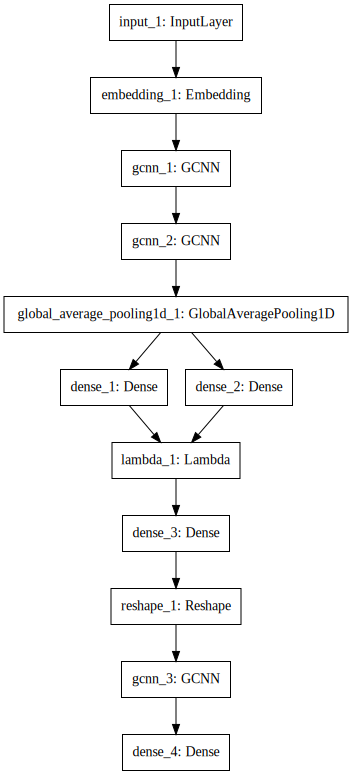

In [6]:
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### 生成五言诗

In [0]:
# 利用生成模型随机生成一首诗
def gen():
    r = generator.predict(np.random.randn(1, latent_dim))[0]
    r = r.argmax(axis=1)
    return ''.join([id2char[i] for i in r[:n]])\
           + u'，'\
           + ''.join([id2char[i] for i in r[n:]])


# 回调器，方便在训练过程中输出
class Evaluate(Callback):
    def __init__(self):
        self.log = []
    def on_epoch_end(self, epoch, logs=None):
        self.log.append(gen())
        print (u'          %s'%(self.log[-1]))


evaluator = Evaluate()

vae.fit(poem2id,
        shuffle=True,
        epochs=100,
        batch_size=64,
        callbacks=[evaluator])

vae.save_weights('shi.model')

for i in range(20):
    print(gen())

Epoch 1/100
148410/148410 [==============================] - 68s 457us/step - loss: 61.2076
          夜起卷青户，月上明月起
Epoch 2/100
148410/148410 [==============================] - 68s 455us/step - loss: 61.2007
          恋云方惨漫，穷日恨凄凄
Epoch 3/100
148410/148410 [==============================] - 63s 423us/step - loss: 61.1754
          谁问鞭死死，何今生祸肠
Epoch 4/100
148410/148410 [==============================] - 50s 334us/step - loss: 61.1877
          天若白龙底，天如金石开
Epoch 5/100
148410/148410 [==============================] - 50s 334us/step - loss: 61.1715
          鬓发云中去，云归北上来
Epoch 6/100
143296/148410 [===========================>..] - ETA: 1s - loss: 61.1599